# Khởi tạo spark

In [1]:
import findspark
findspark.init()

import pyspark
findspark.find()

from pyspark.sql import SparkSession
from pyspark.sql.functions import count

sc = (SparkSession
      .builder
      .appName("sql_ex1")
      .getOrCreate())

# Đọc và load tập dữ liệu New York City Airbnb

In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.sql.functions import *
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType, IntegerType
import matplotlib.pyplot as plt
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import FMRegressor

In [3]:
df = sc.read.csv("./AB_NYC_2019.csv", header=True)
df.show(3)

+----+--------------------+-------+---------+-------------------+-------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+
|  id|                name|host_id|host_name|neighbourhood_group|neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|
+----+--------------------+-------+---------+-------------------+-------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+
|2539|Clean & quiet apt...|   2787|     John|           Brooklyn|   Kensington|40.64749|-73.97237|   Private room|  149|             1|                9| 2018-10-19|             0.21|                             6|             365|
|2595|Skylit Midtown Ca...|   2845| Jennifer|          Manhattan|      M

# Tập  dữ  liệu  New  York  City  Airbnb

Tập Dữ Liệu AB_NYC_2019.csv chứa 48895 bản ghi

Tập dữ liệu có tất cả 16 cột tương ứng với 16 biến:

$id$      : Id danh sách

$name$    : tên địa điểm của danh sách

$host__id$ : ID máy chủ

$host__name$  : tên của chủ nhà

$neighbourhood__group$ :  vị trí

$neighbourhood$ : Khu vực

$latitude$ : tọa độ vĩ độ

$longitude$ : tọa độ kinh độ

$room__type$ : loại phòng ở trong danh sách (Entire home/apt, Private room, Shared room)

$price$ : giá bằng đô la

$minimum__nights$ : số đêm tối thiểu

$number__of__reviews$ : số lượng đánh giá

$last__review$ : đánh giá mới nhất

$reviews__per__month$ : số lượng đánh giá mỗi tháng

$calculated__host__listings__count$ : số lượng danh sách trên mỗi máy chủ    

$availability__365$ : số ngày khi danh sách có sẵn để đặt

# Xem các loại biến trong tập dữ liệu

In [4]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- host_name: string (nullable = true)
 |-- neighbourhood_group: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- price: string (nullable = true)
 |-- minimum_nights: string (nullable = true)
 |-- number_of_reviews: string (nullable = true)
 |-- last_review: string (nullable = true)
 |-- reviews_per_month: string (nullable = true)
 |-- calculated_host_listings_count: string (nullable = true)
 |-- availability_365: string (nullable = true)



In [5]:
df.dtypes

[('id', 'string'),
 ('name', 'string'),
 ('host_id', 'string'),
 ('host_name', 'string'),
 ('neighbourhood_group', 'string'),
 ('neighbourhood', 'string'),
 ('latitude', 'string'),
 ('longitude', 'string'),
 ('room_type', 'string'),
 ('price', 'string'),
 ('minimum_nights', 'string'),
 ('number_of_reviews', 'string'),
 ('last_review', 'string'),
 ('reviews_per_month', 'string'),
 ('calculated_host_listings_count', 'string'),
 ('availability_365', 'string')]

# Tiến hành làm sạch dữ liệu
(Lọc và giữ lại các cột có liên quan)

In [6]:
df2 = df.select('neighbourhood_group', 'neighbourhood', 'room_type', 'price', \
               'minimum_nights','number_of_reviews', 'last_review', 'reviews_per_month', \
               'calculated_host_listings_count', 'availability_365', 'latitude', 'longitude')

# chuyển đổi các cột "last_review" từ kiểu chuỗi thành ngày

In [7]:
df2 = df2.withColumn("last_review", to_date(df2.last_review, 'yyyy-MM-dd'))
df2.show(5)

+-------------------+-------------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+--------+---------+
|neighbourhood_group|neighbourhood|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|latitude|longitude|
+-------------------+-------------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+--------+---------+
|           Brooklyn|   Kensington|   Private room|  149|             1|                9| 2018-10-19|             0.21|                             6|             365|40.64749|-73.97237|
|          Manhattan|      Midtown|Entire home/apt|  225|             1|               45| 2019-05-21|             0.38|                             2|             355|40.75362|-73.98377|
|          Manhattan|       Harlem|   Private room|  150|   

In [8]:
df2.dtypes

[('neighbourhood_group', 'string'),
 ('neighbourhood', 'string'),
 ('room_type', 'string'),
 ('price', 'string'),
 ('minimum_nights', 'string'),
 ('number_of_reviews', 'string'),
 ('last_review', 'date'),
 ('reviews_per_month', 'string'),
 ('calculated_host_listings_count', 'string'),
 ('availability_365', 'string'),
 ('latitude', 'string'),
 ('longitude', 'string')]

# Tìm điểm zero mà last_review (lần đánh giá cuối) đã diễn ra

In [9]:
max_date = df2.select(max("last_review")).collect()
max_date[0][0]

datetime.date(2019, 7, 8)

In [10]:
datediff(lit(max_date[0][0]),lit(max_date[0][0]))

Column<'datediff(DATE '2019-07-08', DATE '2019-07-08')'>

# Từ giá trị zero point này, chúng tôi có thể ước tính được từ bài đánh giá cuối cùng được cập nhật là bao nhiêu ngày. Chúng ta có thể gọi cột này là 'chênh lệch tính theo ngày'

In [11]:
df2 = df2.withColumn("diff_in_days", datediff(lit(max_date[0][0]), col("last_review")))
df2.show(5)

+-------------------+-------------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+--------+---------+------------+
|neighbourhood_group|neighbourhood|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|latitude|longitude|diff_in_days|
+-------------------+-------------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+--------+---------+------------+
|           Brooklyn|   Kensington|   Private room|  149|             1|                9| 2018-10-19|             0.21|                             6|             365|40.64749|-73.97237|         262|
|          Manhattan|      Midtown|Entire home/apt|  225|             1|               45| 2019-05-21|             0.38|                             2|             355|40.75362|-73.98377|         

# Chuyển đổi các cột sau thành biến phân loại

In [12]:
def date_replacement(date):
    if date is None:
        return "never" 
    elif date <=3:
        return "three_days_ago"
    elif date <= 7:
        return "last_week_ago"
    elif date <= 30:
        return "last_month_ago"
    elif date <= 183:
        return "half_year_ago"
    elif date <= 365:
        return "one_year_ago"
    elif date <= 1825:
        return "5_years_ago"
    else:
        return "never"

from pyspark.sql.types import StringType
    
convertUDF = udf(lambda z: date_replacement(z),StringType())
    
df2 = df2.withColumn("diff_in_days", convertUDF(df2.diff_in_days))
df2.show(5)

+-------------------+-------------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+--------+---------+--------------+
|neighbourhood_group|neighbourhood|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|latitude|longitude|  diff_in_days|
+-------------------+-------------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+--------+---------+--------------+
|           Brooklyn|   Kensington|   Private room|  149|             1|                9| 2018-10-19|             0.21|                             6|             365|40.64749|-73.97237|  one_year_ago|
|          Manhattan|      Midtown|Entire home/apt|  225|             1|               45| 2019-05-21|             0.38|                             2|             355|40.75362|-73.98377| 

# Nhập truyền tất cả các cột kiểu chuỗi thành kiểu số nguyên (interger) và kiểu thực (floats)

In [13]:
df2 = df2.withColumn("price", df2["price"].cast(IntegerType()))
df2 = df2.withColumn("minimum_nights", df2["minimum_nights"].cast(IntegerType()))
df2 = df2.withColumn("number_of_reviews", df2["number_of_reviews"].cast(IntegerType()))
df2 = df2.withColumn("reviews_per_month", df2["reviews_per_month"].cast(FloatType()))
df2 = df2.withColumn("calculated_host_listings_count", df2["calculated_host_listings_count"].cast(IntegerType()))
df2 = df2.withColumn("availability_365", df2["availability_365"].cast(IntegerType()))
df2 = df2.withColumn("latitude", df2["latitude"].cast(FloatType()))
df2 = df2.withColumn("longitude", df2["longitude"].cast(FloatType()))

In [14]:
df2.show(5)

+-------------------+-------------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+--------+---------+--------------+
|neighbourhood_group|neighbourhood|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|latitude|longitude|  diff_in_days|
+-------------------+-------------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+--------+---------+--------------+
|           Brooklyn|   Kensington|   Private room|  149|             1|                9| 2018-10-19|             0.21|                             6|             365|40.64749|-73.97237|  one_year_ago|
|          Manhattan|      Midtown|Entire home/apt|  225|             1|               45| 2019-05-21|             0.38|                             2|             355|40.75362|-73.98377| 

# Thay thế các giá trị null bằng 0

In [15]:
df2 = df2.na.fill(value=0,subset=["reviews_per_month"])

In [16]:
df2.show(5)

+-------------------+-------------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+--------+---------+--------------+
|neighbourhood_group|neighbourhood|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|latitude|longitude|  diff_in_days|
+-------------------+-------------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+--------+---------+--------------+
|           Brooklyn|   Kensington|   Private room|  149|             1|                9| 2018-10-19|             0.21|                             6|             365|40.64749|-73.97237|  one_year_ago|
|          Manhattan|      Midtown|Entire home/apt|  225|             1|               45| 2019-05-21|             0.38|                             2|             355|40.75362|-73.98377| 

In [17]:
df2.dtypes

[('neighbourhood_group', 'string'),
 ('neighbourhood', 'string'),
 ('room_type', 'string'),
 ('price', 'int'),
 ('minimum_nights', 'int'),
 ('number_of_reviews', 'int'),
 ('last_review', 'date'),
 ('reviews_per_month', 'float'),
 ('calculated_host_listings_count', 'int'),
 ('availability_365', 'int'),
 ('latitude', 'float'),
 ('longitude', 'float'),
 ('diff_in_days', 'string')]

In [18]:
df2 = df2.na.drop(how="any")
df2.show(5)

+-------------------+-------------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+--------+---------+--------------+
|neighbourhood_group|neighbourhood|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|latitude|longitude|  diff_in_days|
+-------------------+-------------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+--------+---------+--------------+
|           Brooklyn|   Kensington|   Private room|  149|             1|                9| 2018-10-19|             0.21|                             6|             365|40.64749|-73.97237|  one_year_ago|
|          Manhattan|      Midtown|Entire home/apt|  225|             1|               45| 2019-05-21|             0.38|                             2|             355|40.75362|-73.98377| 

# Ma trận tương quan (Correlation Matrix)

In [19]:
df_viz = df2.toPandas()
df_viz.corr().style.background_gradient(cmap='coolwarm').set_precision(2)


,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,latitude,longitude
price,1.00,0.03,-0.04,-0.03,0.05,0.08,0.03,-0.16
minimum_nights,0.03,1.00,-0.07,-0.12,0.07,0.10,0.03,-0.06
number_of_reviews,-0.04,-0.07,1.00,0.55,-0.06,0.19,-0.01,0.05
reviews_per_month,-0.03,-0.12,0.55,1.00,-0.01,0.18,-0.01,0.14
calculated_host_listings_count,0.05,0.07,-0.06,-0.01,1.00,0.18,0.00,-0.09
availability_365,0.08,0.10,0.19,0.18,0.18,1.00,-0.02,0.10
latitude,0.03,0.03,-0.01,-0.01,0.00,-0.02,1.00,0.09
longitude,-0.16,-0.06,0.05,0.14,-0.09,0.10,0.09,1.00


# Boxplot

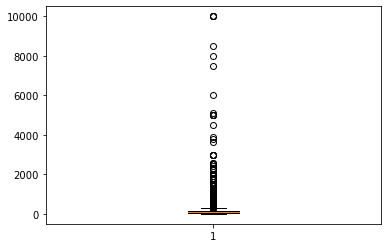

In [20]:
plt.boxplot(df_viz[['price']])
plt.show()

In [21]:
df2 = df2.filter(df2.price<=250)

<AxesSubplot:>

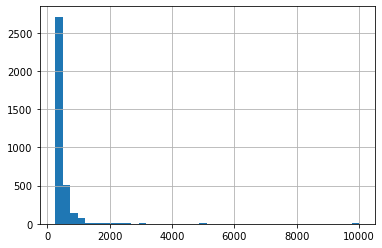

In [22]:
df_viz[df_viz['price']>250].price.hist(bins=40)

# Loại bỏ các giá trị lớn hơn 250

# Số hàng có thể bị loại bỏ

In [23]:
df_viz[df_viz['price']>250].price.value_counts().sum()

3520

# Phân phối sau khi loại bỏ các ngoại lệ (Outlier)

<AxesSubplot:>

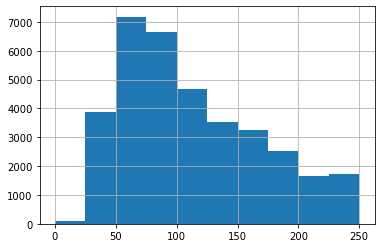

In [24]:
df_viz[df_viz['price']<=250].price.hist()

# Giả sư cho thuê có tính phí

In [25]:
df2 = df2.filter(df2.price!=0)

In [26]:
df2.dtypes

[('neighbourhood_group', 'string'),
 ('neighbourhood', 'string'),
 ('room_type', 'string'),
 ('price', 'int'),
 ('minimum_nights', 'int'),
 ('number_of_reviews', 'int'),
 ('last_review', 'date'),
 ('reviews_per_month', 'float'),
 ('calculated_host_listings_count', 'int'),
 ('availability_365', 'int'),
 ('latitude', 'float'),
 ('longitude', 'float'),
 ('diff_in_days', 'string')]

# Mã hóa vùng lân cận, loại phòng và diff_in_days bằng Pipelines

# String indexer and then one-hot encoding

In [27]:
ng_indexer = StringIndexer(inputCol="neighbourhood_group", outputCol="ng1")
n_indexer = StringIndexer(inputCol="neighbourhood", outputCol="n1")
rt_indexer = StringIndexer(inputCol="room_type", outputCol="rt1")
dfd_indexer = StringIndexer(inputCol="diff_in_days", outputCol="dfd1")

ng_onehot = OneHotEncoder(inputCol="ng1", outputCol="ngv")
n_onehot = OneHotEncoder(inputCol="n1", outputCol="nv")
rt_onehot = OneHotEncoder(inputCol="rt1", outputCol="rtv")
dfd_onehot = OneHotEncoder(inputCol="dfd1", outputCol="dfdv")

pipeline = Pipeline(stages=[ng_indexer, n_indexer, rt_indexer, dfd_indexer, \
                            ng_onehot, n_onehot, rt_onehot, dfd_onehot])
df3 = pipeline.fit(df2).transform(df2)
df3.show(5)

+-------------------+-------------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+--------+---------+--------------+---+----+---+----+-------------+----------------+-------------+-------------+
|neighbourhood_group|neighbourhood|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|latitude|longitude|  diff_in_days|ng1|  n1|rt1|dfd1|          ngv|              nv|          rtv|         dfdv|
+-------------------+-------------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+--------+---------+--------------+---+----+---+----+-------------+----------------+-------------+-------------+
|           Brooklyn|   Kensington|   Private room|  149|             1|                9| 2018-10-19|             0.21|                             6|         

In [28]:
df3.dtypes

[('neighbourhood_group', 'string'),
 ('neighbourhood', 'string'),
 ('room_type', 'string'),
 ('price', 'int'),
 ('minimum_nights', 'int'),
 ('number_of_reviews', 'int'),
 ('last_review', 'date'),
 ('reviews_per_month', 'float'),
 ('calculated_host_listings_count', 'int'),
 ('availability_365', 'int'),
 ('latitude', 'float'),
 ('longitude', 'float'),
 ('diff_in_days', 'string'),
 ('ng1', 'double'),
 ('n1', 'double'),
 ('rt1', 'double'),
 ('dfd1', 'double'),
 ('ngv', 'vector'),
 ('nv', 'vector'),
 ('rtv', 'vector'),
 ('dfdv', 'vector')]

# Biến đổi train data theo định dạng của Spark

In [29]:
va = VectorAssembler(inputCols = \
                     ['minimum_nights', 'number_of_reviews', 'reviews_per_month', \
                      'calculated_host_listings_count', 'availability_365', \
                      'ngv','rtv', 'nv', 'dfdv', 'latitude', 'longitude'], outputCol = 'features')
df4 = va.transform(df3)
df4x = df4.select(['features', 'price'])
df4x.show(5)

+--------------------+-----+
|            features|price|
+--------------------+-----+
|(236,[0,1,2,3,4,5...|  149|
|(236,[0,1,2,3,4,6...|  225|
|(236,[0,1,2,3,4,5...|   89|
|(236,[0,1,2,3,6,1...|   80|
|(236,[0,1,2,3,4,6...|  200|
+--------------------+-----+
only showing top 5 rows



# MinMax Scaler

In [30]:
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
scalerModel = scaler.fit(df4x)
df4 = scalerModel.transform(df4x)
df4.show(5)

+--------------------+-----+--------------------+
|            features|price|      scaledFeatures|
+--------------------+-----+--------------------+
|(236,[0,1,2,3,4,5...|  149|(236,[1,2,3,4,5,9...|
|(236,[0,1,2,3,4,6...|  225|(236,[1,2,3,4,6,1...|
|(236,[0,1,2,3,4,5...|   89|(236,[1,2,4,5,10,...|
|(236,[0,1,2,3,6,1...|   80|(236,[0,1,2,6,10,...|
|(236,[0,1,2,3,4,6...|  200|(236,[0,1,2,4,6,1...|
+--------------------+-----+--------------------+
only showing top 5 rows



In [31]:
df4 = df4.select('scaledFeatures', 'price')
df4 = df4.withColumnRenamed("scaledFeatures","features")
df4 = df4.withColumnRenamed("price","label")
df4.show(2)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(236,[1,2,3,4,5,9...|  149|
|(236,[1,2,3,4,6,1...|  225|
+--------------------+-----+
only showing top 2 rows



# Train-Test

In [32]:
splits = df4.randomSplit([0.8, 0.2], seed=12345)
train_df = splits[0]
test_df = splits[1]

# Linear Regression

In [33]:
df3_raw = df.select('neighbourhood_group', 'neighbourhood', 'room_type', 'price', \
               'minimum_nights','number_of_reviews', 'reviews_per_month', \
               'calculated_host_listings_count', 'availability_365', 'latitude', 'longitude')

df3_raw = df3_raw.na.drop("any")

df3_raw = df3_raw.withColumn("price", df3_raw["price"].cast(IntegerType()))
df3_raw = df3_raw.withColumn("minimum_nights", df3_raw["minimum_nights"].cast(IntegerType()))
df3_raw = df3_raw.withColumn("number_of_reviews", df3_raw["number_of_reviews"].cast(IntegerType()))
df3_raw = df3_raw.withColumn("reviews_per_month", df3_raw["reviews_per_month"].cast(FloatType()))
df3_raw = df3_raw.withColumn("calculated_host_listings_count", df3_raw["calculated_host_listings_count"].cast(IntegerType()))
df3_raw = df3_raw.withColumn("availability_365", df3_raw["availability_365"].cast(IntegerType()))
df3_raw = df3_raw.withColumn("latitude", df3_raw["latitude"].cast(FloatType()))
df3_raw = df3_raw.withColumn("longitude", df3_raw["longitude"].cast(FloatType()))


df3_raw = df3_raw.na.drop("any")

pipeline = Pipeline(stages=[ng_indexer, n_indexer, rt_indexer, \
                            ng_onehot, n_onehot, rt_onehot])
df4_raw = pipeline.fit(df3_raw).transform(df3_raw)

va1 = VectorAssembler(inputCols = \
                     ['minimum_nights', 'number_of_reviews', 'reviews_per_month', \
                        'calculated_host_listings_count', 'availability_365', \
                      'ngv','rtv', 'nv', 'latitude', 'longitude'], outputCol = 'features')

df5_raw = va1.transform(df4_raw)
df5x_raw = df5_raw.select(['features', 'price'])

splits_raw = df5x_raw.randomSplit([0.7, 0.3], seed=12345)
train_df_raw = splits_raw[0]
test_df_raw = splits_raw[1]
#print(train_df_raw.collect()[5])

lr_raw = LinearRegression(featuresCol = 'features', labelCol='price')
lr_model_raw = lr_raw.fit(train_df_raw)
fullPredictions_raw = lr_model_raw.transform(test_df_raw).cache()

lr_evaluator_raw = RegressionEvaluator(predictionCol="prediction", labelCol="price",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator_raw.evaluate(fullPredictions_raw))
lr_evaluator_raw = RegressionEvaluator(predictionCol="prediction", labelCol="price",metricName="rmse")
print("RMSE (R2) on test data = %g" % lr_evaluator_raw.evaluate(fullPredictions_raw))

R Squared (R2) on test data = 0.13579
RMSE (R2) on test data = 184.575


# Decision Tree

Thiết lập mô hình.

In [34]:
dt = DecisionTreeRegressor(featuresCol = 'features', labelCol='label') 
dt_model = dt.fit(train_df)
dtPrediction = dt_model.transform(test_df)

In ra các giá trị Rquared và RMSE để đánh giá mô hình.

In [35]:
dt_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label",metricName="r2")
print("R Squared (R2) on test data = %g" % dt_evaluator.evaluate(dtPrediction))
dt_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label",metricName="rmse")
print("RMSE on test data = %g" % dt_evaluator.evaluate(dtPrediction))

R Squared (R2) on test data = 0.5605
RMSE on test data = 37.3599


### Tuning Hyparameter

In [36]:
dt = DecisionTreeRegressor(featuresCol = 'features', labelCol='label',  maxDepth = 9, maxBins = 13) 
dt_model = dt.fit(train_df)
dtPrediction = dt_model.transform(test_df)

dt_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label",metricName="r2")
print("R Squared (R2) on test data = %g" % dt_evaluator.evaluate(dtPrediction))
dt_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label",metricName="rmse")
print("RMSE on test data = %g" % dt_evaluator.evaluate(dtPrediction))

R Squared (R2) on test data = 0.573146
RMSE on test data = 36.8185


# Random Forest

Thiết lập mô hình.

In [37]:
rf = RandomForestRegressor(featuresCol = 'features', labelCol='label')
rf_model = rf.fit(train_df)
rfPredictions = rf_model.transform(test_df)

In ra các giá trị Rquared và RMSE để đánh giá mô hình.

In [38]:
rf_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label",metricName="r2")
print("R Squared (R2) on test data = %g" % rf_evaluator.evaluate(rfPredictions))
rf_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label",metricName="rmse")
print("RMSE on test data = %g" % rf_evaluator.evaluate(rfPredictions))

R Squared (R2) on test data = 0.556358
RMSE on test data = 37.5356


### Tuning hyparameters

In [33]:
rf = RandomForestRegressor(featuresCol = 'features', labelCol='label', maxDepth = 14)
rf_model = rf.fit(train_df)
rfPredictions = rf_model.transform(test_df)

rf_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label",metricName="r2")
print("R Squared (R2) on test data = %g" % rf_evaluator.evaluate(rfPredictions))
rf_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label",metricName="rmse")
print("RMSE on test data = %g" % rf_evaluator.evaluate(rfPredictions))

R Squared (R2) on test data = 0.612062
RMSE on test data = 35.1


Tiến hành dự đoán.

In [49]:
rfPredictions.show(5)

+--------------------+-----+------------------+
|            features|label|        prediction|
+--------------------+-----+------------------+
|(236,[0,1,2,3,4,5...|   51|  68.6468192429817|
|(236,[0,1,2,3,4,5...|   60| 64.77113899405927|
|(236,[0,1,2,3,4,5...|   46| 67.20110719140075|
|(236,[0,1,2,3,4,5...|   75| 71.91950773443997|
|(236,[0,1,2,3,4,5...|   95|60.874555377365404|
+--------------------+-----+------------------+
only showing top 5 rows

